In [1]:
#Import Libraries
import pandas as pd
import os
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
#rcParams['figure.figsize']=16,15
rcParams.update({'font.size': 14})
# pd.options.display.max_columns = 25
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from numpy import argmax
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, average_precision_score

In [2]:
## Loading the data

train = pd.read_csv('ENROLLMENT_DATA.csv')

In [3]:
train.head(3)

,Target_Enroll,avg_income,CAMPUS_VISIT,CONTACT_CODE1,Contact_Date,Contact_Month,Contact_Year,distance,ETHNICITY,hscrat,ID,init_span,Instate,int1rat,int2rat,interest,IRSCHOOL,LEVEL_YEAR,mailq,premiere,REFERRAL_CNTCTS,satscore,SELF_INIT_CNTCTS,sex,SOLICITED_CNTCTS,telecq,TERRITORY,TOTAL_CONTACTS,TRAVEL_INIT_CNTCTS,Total,AllocProportion,SampleSize,ActualProportion,SelectionProb,SamplingWeight
0,0,NaN,0,EML,1,Sep,2012,NaN,NaN,0.037652,32,48,N,0.017183,0.02038,0,NaN,FR04,5,0,0,NaN,1,1.0,0,NaN,N,1,0,2580,0.5,2322,0.5,0.9,1.111111
1,0,NaN,0,SAT,12,Feb,2014,NaN,N,0.037652,51,31,N,0.017183,0.02038,0,NaN,FR04,5,0,0,NaN,1,1.0,0,NaN,N,1,0,2580,0.5,2322,0.5,0.9,1.111111
2,0,NaN,0,C01,16,Jan,2015,NaN,C,0.037652,120,20,N,0.017183,0.02038,0,NaN,FR04,5,0,0,NaN,0,1.0,1,NaN,N,1,0,2580,0.5,2322,0.5,0.9,1.111111


## **Functions**

In [4]:
#Function to identify target proportion, missing values, missing value proportion and unique levels for each category variable
def dataexplore(df,value):
  if value =='targetprop':
    d = pd.DataFrame(df['Target_Enroll'].value_counts()).apply(lambda x: x/x.sum()*100)
    return d
  if value =='na':
    d= df.isna().sum()
    return d
  if value=='missingprop':
    col=df.columns[~df.columns.isin(['Target_Enroll'])]
    d = pd.DataFrame(df.set_index('Target_Enroll')[col].isna().sum(level=0)).apply(lambda x: x/x.sum())
    return d
  if value =='uniquelevel':
    d= df.nunique()
    return d

In [5]:
#Function to plot count and bar graphs for given variables
def visualization(df,columns,kind):
  f,ax=plt.subplots(2,2,figsize=(22,12))
  f.delaxes(ax[1,1])
  for i, col in enumerate(columns):
    plt.figure(i)
    plt.figure(figsize=(8, 8))
    plt.tight_layout()
  #plt.ylim((0,100))
    if kind=='bar':
      splot=sns.barplot(x='Target_Enroll',y=col,ax=ax[i//2,i%2],data=df,palette="Blues")
    if kind=='count':
      splot=sns.countplot(x=col,hue='Target_Enroll',ax=ax[i//2,i%2], data=df,palette="Blues")
    for p in splot.patches:
        a= splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
  return a

In [6]:
#Function to encode ordinal/date variables and remove missing values from the data. It returns a clean encoded dataset.
def preprocessing(df):
    d=df.copy(deep=True)
    Contact_Month_d={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    Instate_d={'N':0,'Y':1}
    d['Contact_Month']=d.Contact_Month.map(Contact_Month_d)
    d['Instate']=d.Instate.map(Instate_d)
    d.dropna(axis=0, how='any',inplace=True)
    #d.drop(['ord_5','day','month'],axis=1,inplace=True)
    #d.fillna(999,inplace=True)
    return d

In [7]:
# Function for RandomForest_model.
## This function is a wrapper around the Random Forest Classifier function in Sklearn.

def RandomForest(x, y, **kwargs):
    RandomForest_model = RandomForestClassifier(**kwargs)
    RandomForest_model.fit(x, y)
    return RandomForest_model

In [8]:
#Function for Prediction
def predict(trained_model,x):
     prediction=trained_model.predict(x)
     return prediction

In [9]:
#Function for Plotting ROC Curve
def plot_roc_curve(fpr, tpr,auc):
    f, ax = plt.subplots(figsize=(10, 8))
    plt.plot(fpr, tpr, color='steelblue', label='ROC')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.xlabel('False Positive Rate',fontsize=13)
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.title('Receiver Operating Characteristic (ROC) Curve',fontsize=14)
    plt.legend(['AUC: %.3f' % auc],fontsize=10)
    #plt.show()


In [10]:
#Function for plotting GridSearchCV results
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=25,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='black')
        plt.axhline(y=best_mean - best_stdev, color='black')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()


## **Class For MultiColumnLabelEncoding**

[Classes & Objects in Python](https://www.geeksforgeeks.org/python-classes-and-objects/)

In [11]:
#Class for MultiColumn Label Encoding. Sklearn's LabelEncoding class can't handle multiple variables at a time
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

## **Data Exploration**  

In [12]:
# List out all columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4644 entries, 0 to 4643
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Target_Enroll       4644 non-null   int64  
 1   avg_income          3961 non-null   float64
 2   CAMPUS_VISIT        4644 non-null   int64  
 3   CONTACT_CODE1       4639 non-null   object 
 4   Contact_Date        4644 non-null   int64  
 5   Contact_Month       4644 non-null   object 
 6   Contact_Year        4644 non-null   int64  
 7   distance            4042 non-null   float64
 8   ETHNICITY           4107 non-null   object 
 9   hscrat              4644 non-null   float64
 10  ID                  4644 non-null   int64  
 11  init_span           4644 non-null   int64  
 12  Instate             4644 non-null   object 
 13  int1rat             4644 non-null   float64
 14  int2rat             4644 non-null   float64
 15  interest            4644 non-null   int64  
 16  IRSCHO

In [13]:
#Check target class(%)
dataexplore(train,'targetprop')

,Target_Enroll
0,50.0
1,50.0


In [14]:
#Check missing value proportion across target class for each variable
dataexplore(train,'missingprop')

,avg_income,CAMPUS_VISIT,CONTACT_CODE1,Contact_Date,Contact_Month,Contact_Year,distance,ETHNICITY,hscrat,ID,init_span,Instate,int1rat,int2rat,interest,IRSCHOOL,LEVEL_YEAR,mailq,premiere,REFERRAL_CNTCTS,satscore,SELF_INIT_CNTCTS,sex,SOLICITED_CNTCTS,telecq,TERRITORY,TOTAL_CONTACTS,TRAVEL_INIT_CNTCTS,Total,AllocProportion,SampleSize,ActualProportion,SelectionProb,SamplingWeight
Target_Enroll,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.805271,NaN,1.0,NaN,NaN,NaN,0.858804,0.990689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.999413,NaN,0.981982,NaN,0.66315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.194729,NaN,0.0,NaN,NaN,NaN,0.141196,0.009311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000587,NaN,0.018018,NaN,0.33685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#Check missing value count for each variable
dataexplore(train,'na')

Target_Enroll            0
avg_income             683
CAMPUS_VISIT             0
CONTACT_CODE1            5
Contact_Date             0
Contact_Month            0
Contact_Year             0
distance               602
ETHNICITY              537
hscrat                   0
ID                       0
init_span                0
Instate                  0
int1rat                  0
int2rat                  0
interest                 0
IRSCHOOL               385
LEVEL_YEAR               0
mailq                    0
premiere                 0
REFERRAL_CNTCTS          0
satscore              1704
SELF_INIT_CNTCTS         0
sex                    111
SOLICITED_CNTCTS         0
telecq                2749
TERRITORY                0
TOTAL_CONTACTS           0
TRAVEL_INIT_CNTCTS       0
Total                    0
AllocProportion          0
SampleSize               0
ActualProportion         0
SelectionProb            0
SamplingWeight           0
dtype: int64

In [16]:
#Check unique levels for each variable
dataexplore(train,'uniquelevel')

Target_Enroll            2
avg_income            1607
CAMPUS_VISIT             3
CONTACT_CODE1           87
Contact_Date            31
Contact_Month           12
Contact_Year             7
distance              1696
ETHNICITY                7
hscrat                 302
ID                    4644
init_span               58
Instate                  2
int1rat                124
int2rat                112
interest                 4
IRSCHOOL              1654
LEVEL_YEAR               1
mailq                    4
premiere                 2
REFERRAL_CNTCTS          6
satscore                97
SELF_INIT_CNTCTS        20
sex                      2
SOLICITED_CNTCTS         8
telecq                   4
TERRITORY               11
TOTAL_CONTACTS          22
TRAVEL_INIT_CNTCTS       6
Total                    1
AllocProportion          1
SampleSize               1
ActualProportion         1
SelectionProb            1
SamplingWeight           1
dtype: int64

## **Clean Data**

In [17]:
#Final set with no missing values and encoded ordinal variables
final=preprocessing(train)

In [18]:
final.head()

,Target_Enroll,avg_income,CAMPUS_VISIT,CONTACT_CODE1,Contact_Date,Contact_Month,Contact_Year,distance,ETHNICITY,hscrat,ID,init_span,Instate,int1rat,int2rat,interest,IRSCHOOL,LEVEL_YEAR,mailq,premiere,REFERRAL_CNTCTS,satscore,SELF_INIT_CNTCTS,sex,SOLICITED_CNTCTS,telecq,TERRITORY,TOTAL_CONTACTS,TRAVEL_INIT_CNTCTS,Total,AllocProportion,SampleSize,ActualProportion,SelectionProb,SamplingWeight
127,0,56800.0,0,LMI,15,4,2015,1109.906318,C,0.0,4517,17,0,0.017183,0.020380,0,343225,FR04,5,1,0,950.0,9,1.0,1,2.0,2,10,0,2580,0.5,2322,0.5,0.9,1.111111
144,0,95468.0,0,EML,4,4,2014,781.139903,C,0.0,4930,29,0,0.017183,0.020380,0,110146,FR04,1,0,0,1110.0,7,1.0,0,3.0,2,9,2,2580,0.5,2322,0.5,0.9,1.111111
208,0,43725.0,0,SAT,26,12,2014,919.654798,C,0.0,7204,21,0,0.017183,0.020380,0,101258,FR04,5,0,0,1190.0,2,0.0,0,2.0,2,2,0,2580,0.5,2322,0.5,0.9,1.111111
214,0,62987.0,1,LMI,30,10,2014,625.421644,C,0.0,7486,23,0,0.019969,0.011236,0,10380,FR04,5,0,0,1110.0,5,1.0,1,2.0,2,6,0,2580,0.5,2322,0.5,0.9,1.111111
251,0,47676.0,0,CIP,9,1,2015,489.447110,C,0.0,9110,20,0,0.026087,0.017637,0,430453,FR04,2,1,0,1110.0,10,1.0,0,2.0,8,11,1,2580,0.5,2322,0.5,0.9,1.111111


## **Train-Validation Split**

In [19]:
final = final.drop(['CONTACT_CODE1', 'ID','IRSCHOOL','LEVEL_YEAR','Total','AllocProportion','SampleSize','ActualProportion','SelectionProb','SamplingWeight'], axis=1)

In [20]:
#Splitting the dataframe into Training set(70%) and Validation set(30%).
X_train, X_val, Y_train, Y_val= train_test_split(final[final.columns[~final.columns.isin(['Target_Enroll'])]],
                                                final['Target_Enroll'],test_size=0.30, random_state=12345)

In [21]:
#Check the % distribution of target class after data split.
dataexplore(pd.DataFrame(Y_train),'targetprop')

,Target_Enroll
1,87.734082
0,12.265918


In [22]:
dataexplore(final,'na')

Target_Enroll         0
avg_income            0
CAMPUS_VISIT          0
Contact_Date          0
Contact_Month         0
Contact_Year          0
distance              0
ETHNICITY             0
hscrat                0
init_span             0
Instate               0
int1rat               0
int2rat               0
interest              0
mailq                 0
premiere              0
REFERRAL_CNTCTS       0
satscore              0
SELF_INIT_CNTCTS      0
sex                   0
SOLICITED_CNTCTS      0
telecq                0
TERRITORY             0
TOTAL_CONTACTS        0
TRAVEL_INIT_CNTCTS    0
dtype: int64

# Decision tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
param_grid = {
    'classifier__max_depth': [5, 10, 15, 20], 
    'classifier__min_samples_leaf': [5, 10, 15, 20],
    'classifier__min_samples_split': [1, 2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5, 10]
}

dec_tr = DecisionTreeClassifier(random_state=12345)

pipeline = Pipeline([
    ('CatBoostEncoding', CatBoostEncoder(cols=['ETHNICITY', 'TERRITORY'], random_state=12345)),
    ('classifier', dec_tr)
])

cross_validation = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
Grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=cross_validation, n_jobs=-1, verbose=2)
GS = Grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [25]:
#Print best grid parameters
print(GS.best_params_)

{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}


In [26]:
pipeline = Pipeline([('CatBoostEncoding', CatBoostEncoder(cols=['ETHNICITY','TERRITORY'],random_state=12345))])
X_train_Enc=pipeline.fit_transform(X_train,Y_train)
X_val_Enc=pipeline.transform(X_val)

In [27]:
#Call Decision Tree classifier function and putting the optimum parameters received through GridSearchCV
DT = DecisionTreeClassifier(max_depth=5,min_samples_leaf=5,min_samples_split=2,random_state=12345)
DT.fit(X_train_Enc,Y_train)

predictprob_val=DT.predict_proba(X_val_Enc)[:,1]
prediction_val=predict(DT,X_val_Enc)

#Calculate AUC score using predicted probabilities on Validation Set
auc_DT = roc_auc_score(Y_val, predictprob_val)
print('AUC: %.3f' % auc_DT)

AUC: 0.799


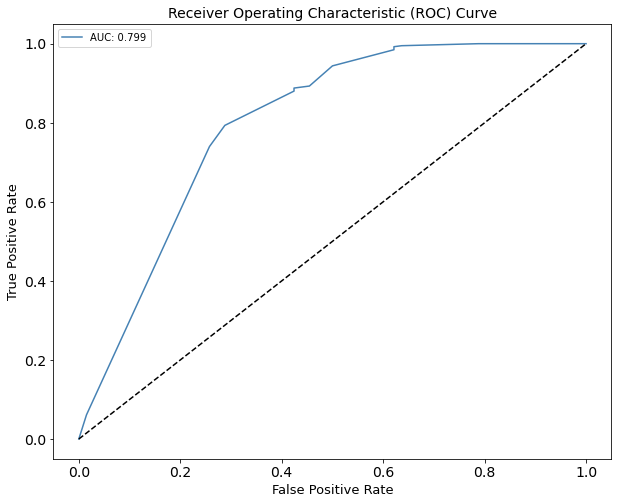

In [28]:
#Calculate FalsePositive and TruePositive rate, and plot ROC Curve for the final RF model with CatBoost Encoding
#https://www.evidentlyai.com/classification-metrics/explain-roc-curve (Refer to the link to understand ROC AUC)
fpr, tpr, thresholds = roc_curve(Y_val, predictprob_val)
plot_roc_curve(fpr, tpr,auc_DT)

# **Random Forest Classifier with explicit encoding for categorical Features**

### **Hyperparameter tuning through Grid Search CV - RF**

[Hyperparameter Optimization Frameworks](https://neptune.ai/blog/best-tools-for-model-tuning-and-hyperparameter-optimization)

[Category Encoders Documentation](#https://contrib.scikit-learn.org/category_encoders/catboost.html)

In [29]:
param_grid = {
    'classifier__max_depth': [5, 10, 15, 20],
    #'max_features': [2, 3, 5, 10],
    'classifier__n_estimators': [50, 100, 200, 300]
}

RF=RandomForestClassifier(random_state=12345, class_weight='balanced') 

pipeline = Pipeline([('CatBoostEncoding', CatBoostEncoder(cols=['ETHNICITY','TERRITORY'],random_state=12345)), ('classifier', RF)])

cross_validation = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
Grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring='roc_auc', cv=cross_validation, n_jobs=-1,verbose = 2)

In [30]:
#Fit the model on the encoded traning set
GS=Grid_search.fit(X_train,Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [31]:
#Print best grid parameters
print(GS.best_params_)

{'classifier__max_depth': 10, 'classifier__n_estimators': 300}


### **Evaluate RF performance on Validation set Using Best Grid Parameters**

Encode categorical Variables

In [32]:
pipeline = Pipeline([('CatBoostEncoding', CatBoostEncoder(cols=['ETHNICITY','TERRITORY'],random_state=12345))])
X_train_Enc=pipeline.fit_transform(X_train,Y_train)
X_val_Enc=pipeline.transform(X_val)

Random Forest Classifier

In [33]:
#Call RandomForest classifier function and putting the optimum parameters received through GridSearchCV
RF = RandomForest(X_train_Enc,Y_train,n_estimators=300, criterion='gini',max_depth=10,random_state=12345)
predictprob_val=RF.predict_proba(X_val_Enc)[:,1]
prediction_val=predict(RF,X_val_Enc)

#Calculate AUC score using predicted probabilities on Validation Set
auc_rf = roc_auc_score(Y_val, predictprob_val)
print('AUC: %.3f' % auc_rf)

AUC: 0.836


 ROC Curve Plot  

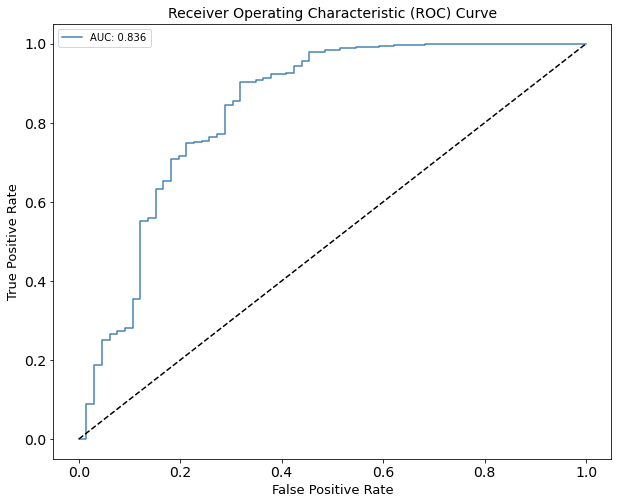

In [34]:
#Calculate FalsePositive and TruePositive rate, and plot ROC Curve for the final RF model with CatBoost Encoding
#https://www.evidentlyai.com/classification-metrics/explain-roc-curve (Refer to the link to understand ROC AUC)
fpr, tpr, thresholds = roc_curve(Y_val, predictprob_val)
plot_roc_curve(fpr, tpr,auc_rf)

# **LightGBM Classifier with in-built encoding for categorical Features**

In [35]:
final.head()

,Target_Enroll,avg_income,CAMPUS_VISIT,Contact_Date,Contact_Month,Contact_Year,distance,ETHNICITY,hscrat,init_span,Instate,int1rat,int2rat,interest,mailq,premiere,REFERRAL_CNTCTS,satscore,SELF_INIT_CNTCTS,sex,SOLICITED_CNTCTS,telecq,TERRITORY,TOTAL_CONTACTS,TRAVEL_INIT_CNTCTS
127,0,56800.0,0,15,4,2015,1109.906318,C,0.0,17,0,0.017183,0.020380,0,5,1,0,950.0,9,1.0,1,2.0,2,10,0
144,0,95468.0,0,4,4,2014,781.139903,C,0.0,29,0,0.017183,0.020380,0,1,0,0,1110.0,7,1.0,0,3.0,2,9,2
208,0,43725.0,0,26,12,2014,919.654798,C,0.0,21,0,0.017183,0.020380,0,5,0,0,1190.0,2,0.0,0,2.0,2,2,0
214,0,62987.0,1,30,10,2014,625.421644,C,0.0,23,0,0.019969,0.011236,0,5,0,0,1110.0,5,1.0,1,2.0,2,6,0
251,0,47676.0,0,9,1,2015,489.447110,C,0.0,20,0,0.026087,0.017637,0,2,1,0,1110.0,10,1.0,0,2.0,8,11,1


In [36]:
#Convert categorical columns to datatype category
cat = ['ETHNICITY','TERRITORY']
X_train[cat]=X_train[cat].astype('category')
X_val[cat]=X_val[cat].astype('category')

In [37]:
#Fit LightGBM Classifier with early stopping to reduce overfitting
LM = lgb.LGBMClassifier(max_depth=9,
                        # num_leaves=72,
                        random_state=12345,
                        objective='binary',
                        boosting_type ='gbdt',
                        feature_fraction='0.3',
                        reg_alpha =1,
                        reg_lambda =1,
                        bagging_fraction='0.8',
                        bagging_freq=10,
                        silent=True,
                        learning_rate='0.1',
                        is_unbalance=False,
                        n_estimators=1500,
#                        categorical_feature=cat,
#                         cat_smooth=10000,
#                         cat_l2=1000,
#                         min_data_per_group=1000,
#                         min_data_in_leaf=1000,
#                         max_bin=30,
#                         min_gain_to_split=1000,
#                         min_data_in_bin =1000,
#                         class_weight=class_weight,
                        metric='auc'
                        #early_stopping=10
                        )
LM.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])
predictprob_val_LM=LM.predict_proba(X_val)[:,1]
prediction_val_LM=predict(LM,X_val)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

In [38]:
param_grid = {
    'max_depth': [5, 7, 9],
    'num_leaves': [64, 72, 80],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'bagging_freq':[5, 10, 20],
    'bagging_fraction':[0.5, 0.8, 1]
}
grid_search = GridSearchCV(estimator=LM, param_grid=param_grid, scoring='roc_auc', cv=2, verbose=1, n_jobs=-1 )

In [39]:
gs = grid_search.fit(X_train, Y_train)

Fitting 2 folds for each of 729 candidates, totalling 1458 fits
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 937, number of negative: 131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

In [40]:
#Print best grid parameters
print(gs.best_params_)

{'bagging_fraction': 0.8, 'bagging_freq': 5, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'num_leaves': 64}


In [41]:
#Fit LightGBM Classifier with early stopping to reduce overfitting
LM = lgb.LGBMClassifier(max_depth=9,
                        num_leaves=64,
                        random_state=12345,
                        objective='binary',
                        boosting_type ='gbdt',
                        feature_fraction='0.3',
                        reg_alpha =1,
                        reg_lambda =1,
                        bagging_fraction='0.8',
                        bagging_freq=5,
                        silent=True,
                        learning_rate='0.1',
                        is_unbalance=False,
                        n_estimators=100,
#                        categorical_feature=cat,
#                         cat_smooth=10000,
#                         cat_l2=1000,
#                         min_data_per_group=1000,
#                         min_data_in_leaf=1000,
#                         max_bin=30,
#                         min_gain_to_split=1000,
#                         min_data_in_bin =1000,
#                         class_weight=class_weight,
                        metric='auc',
                        early_stopping=10
                        )
LM.fit(X_train, Y_train, eval_set=[(X_val, Y_val)])
predictprob_val_LM=LM.predict_proba(X_val)[:,1]
prediction_val_LM=predict(LM,X_val)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 937, number of negative: 131
[LightGBM] [In

Evaluate LightGBM Performance

In [42]:
#Calculate AUC score using predicted probabilities on Validation Set
auc_LM = roc_auc_score(Y_val, predictprob_val_LM)
print('AUC: %.3f' % auc_LM)

AUC: 0.857


 ROC Curve Plot  

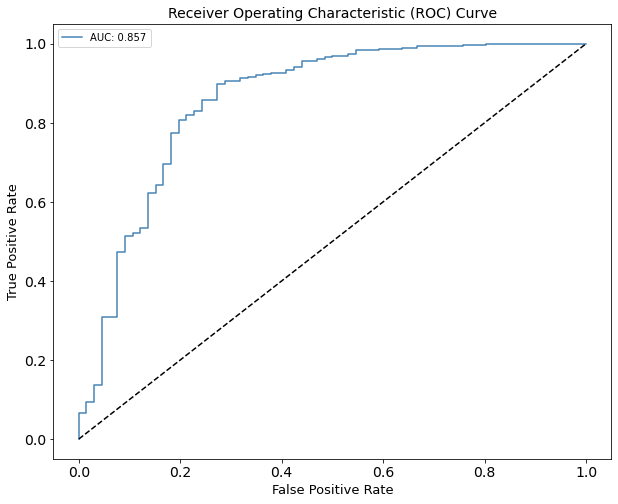

In [43]:
#Claculate FalsePositive and TruePositive rate, and plot ROC Curve for LIghtGBM model with in-built categorical Encoding
fpr, tpr, thresholds = roc_curve(Y_val, predictprob_val_LM)
plot_roc_curve(fpr, tpr,auc_LM)

# XGBOOST

In [44]:
import xgboost as xgb

In [45]:
# Instatiate a XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=123,max_depth=7,num_leaves=72,learning_rate=0.1,n_estimators=100)

In [46]:
pipeline = Pipeline([('CatBoostEncoding', CatBoostEncoder(cols=['ETHNICITY','TERRITORY'],random_state=12345))])
X_train_Enc=pipeline.fit_transform(X_train,Y_train)
X_val_Enc=pipeline.transform(X_val)

In [47]:
param_grid = {
    'max_depth': [5, 7, 9],
    'num_leaves': [64, 72, 80],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000]
}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1 )

In [48]:
gs = grid_search.fit(X_train_Enc, Y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [49]:
#Print best grid parameters
print(gs.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 64}


In [50]:
## Set parameters
xgb_clf.set_params(n_estimators=500, num_leaves=64,max_depth=5,learning_rate=0.01)

# Fit it to the training set
xgb_clf.fit(X_train_Enc, Y_train)

# Predict the labels of the training set
preds_train = xgb_clf.predict(X_train_Enc)

# Predict the labels of the test set
preds_test = xgb_clf.predict(X_val_Enc)

In [51]:
predictprob_val=xgb_clf.predict_proba(X_val_Enc)[:,1]
prediction_val=predict(xgb_clf,X_val_Enc)

In [52]:
#Calculate AUC score using predicted probabilities on Validation Set
auc_xgb = roc_auc_score(Y_val, predictprob_val)
print('AUC: %.3f' % auc_xgb)

AUC: 0.855


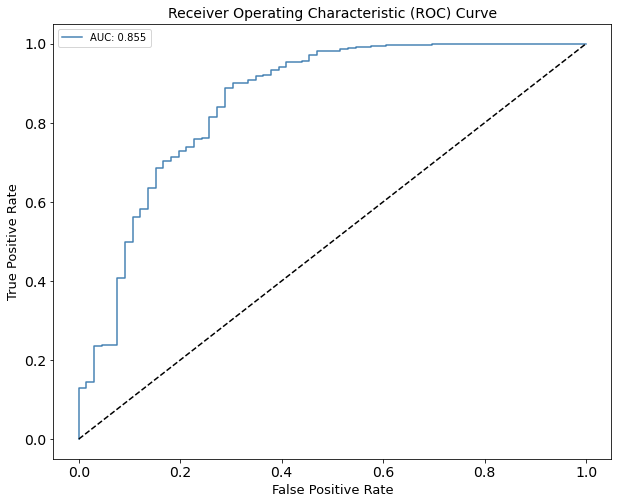

In [53]:
#Claculate FalsePositive and TruePositive rate, and plot ROC Curve for LIghtGBM model with in-built categorical Encoding
fpr, tpr, thresholds = roc_curve(Y_val, predictprob_val)
plot_roc_curve(fpr, tpr,auc_xgb)